In [1]:
from TO_sim.get_rrrp import get_K_r_rp

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

from numba import njit
from numba.types import intc, CPointer, float64
from numba import cfunc, carray, jit
from scipy import LowLevelCallable

from scipy.integrate import quad
from scipy.optimize import brentq
import numpy as np

from tqdm.notebook import tqdm
import pandas as pd
from scipy import interpolate

In [28]:
def jit_integrand_function(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)


def jit_integrand_function3(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm+shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x+O_pm+shift_O)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)
    # return 1/(2*(m*(x)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)


@jit_integrand_function2
def integrand_Rl3(x, X,O_pm,shift_O,m):
    return g(x,0,1)*np.sqrt(1-((x-O_pm-shift_O)/X)**2)


@jit_integrand_function2
def integrand_Rd3(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x-O_pm-shift_O)**2+1/m))*g(x,0,1)


def RP_diff(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        RP_d, _ = quad(integrand_Rd, OP + delta_P + OPs, np.inf, args=(K * rp, 0, 1, m), limit=200)

        return RP_l - RP_d - rp
    except:
        return np.nan


def RP_l(rp, K, r0, OP, m):
    try:
        a = 1 / np.sqrt(K * rp * m)
        b = 4 / np.pi * a - 0.3056 * a**3
        if a > 1.193: b = 1
        b = min(b, 1)
        OPs = max(b * K * rp, 0)

        delta_P = (m * K**2 * r0 * rp) / (2 * (m**2 * OP**2 + 1)) + (K**2 * rp**2) / (4 * OP * (4 * m**2 * OP**2 + 1))

        RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
        return RP_l
    except:
        return np.nan


def get_K_r_rp_full(m):
    Xs1 = np.logspace(-15,-3,2000)
    Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

    R_ls = []
    R_drs = []


    for X in Xs:
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        R_ls.append(R_l)
        R_drs.append(R_dr)


    R0 = np.array(R_ls)
    RD = 2*np.array(R_drs)
    R = R0 -RD
    KK = 1/(R/Xs)
    K_min_arg = np.argmin(KK)

    K_d = KK[:K_min_arg]
    K_u = KK[K_min_arg:]
    r_d = Xs[:K_min_arg]/K_d
    r_u = Xs[K_min_arg:]/K_u
    R_0d = R0[:K_min_arg]
    R_0u = R0[K_min_arg:]
    R_dd = -RD[:K_min_arg]
    R_du = -RD[K_min_arg:]

    R_u = R_0u + R_du
    R_d = R_0d + R_dd
    K_start = KK[K_min_arg]
    Xsu = Xs[K_min_arg:]
    Xsd = Xs[:K_min_arg]

    a = 1/np.sqrt(Xsu*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPS = b*Xsu


    a = 1/np.sqrt(Xsd*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    OPSd = b*Xsd


    RP1_d = []
    RP1_u = []
    RPl_d = []
    RPl_u = []
    K1p = []

    for K, r, r0, OP in zip(K_u, R_u, R_0u, OPS):
        # 1. 적당한 간격으로 샘플
        rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
        diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])


        # 2. sign change 구간 찾기 (교점 후보)
        sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]

        try:
            # 첫 번째 교점
            i1 = sign_change[0]
            if len(sign_change) == 1:
                rp_left = 0
                RP1_d.append(0)
                RPl_d.append(0)
                
            else:
                rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))
                RP1_d.append(rp_left)
                RPl_d.append(RP_l(rp_left, K, r0, OP, m))


                
            # 두 번째 교점
            i2 = sign_change[-1]
            rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))

            RP1_u.append(rp_right)
            RPl_u.append(RP_l(rp_right, K, r0, OP, m))
            K1p.append(K)
        except:
            K1p.append(K)
            RP1_d.append(np.nan)
            RP1_u.append(np.nan)
            RPl_d.append(np.nan)
            RPl_u.append(np.nan)


    K1p = np.array(K1p)
    RP1_u = np.array(RP1_u)
    RPl_u = np.array(RPl_u)
    RP1_d = np.array(RP1_d)
    RPl_d = np.array(RPl_d)


    arg, = np.where(RP1_u<1e-13)
    K1p[arg] = np.nan
    RPl_u[arg] = np.nan
    RP1_u[arg] = np.nan
    RPl_d[arg] = np.nan
    RP1_d[arg] = np.nan
    return R_u,R_0u,R_d,R_0d,RP1_u,RPl_u,RP1_d,RPl_d,K1p,K_start


In [23]:
m = 6

In [24]:
Xs1 = np.logspace(-15,-3,2000)
Xs = np.r_[Xs1,np.linspace(1e-3,60,10001)]

R_ls = []
R_drs = []


for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls.append(R_l)
    R_drs.append(R_dr)


R0 = np.array(R_ls)
RD = 2*np.array(R_drs)
R = R0 -RD
KK = 1/(R/Xs)
K_min_arg = np.argmin(KK)

K_d = KK[:K_min_arg]
K_u = KK[K_min_arg:]
r_d = Xs[:K_min_arg]/K_d
r_u = Xs[K_min_arg:]/K_u
R_0d = R0[:K_min_arg]
R_0u = R0[K_min_arg:]
R_dd = -RD[:K_min_arg]
R_du = -RD[K_min_arg:]

R_u = R_0u + R_du
R_d = R_0d + R_dd
K_start = KK[K_min_arg]
Xsu = Xs[K_min_arg:]
Xsd = Xs[:K_min_arg]

a = 1/np.sqrt(Xsu*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPS = b*Xsu


a = 1/np.sqrt(Xsd*m)
b = 4/np.pi * a - 0.3056*a**3
b = np.where(np.where(a>1.193,1,b)>=1,1,b)
OPSd = b*Xsd

In [60]:
F_K_OPS = interpolate.interp1d(K_u,OPS)

In [71]:
K_s = np.arange(3,10,1)
OPS_s = F_K_OPS(K_s)


(0.0, 1.0)

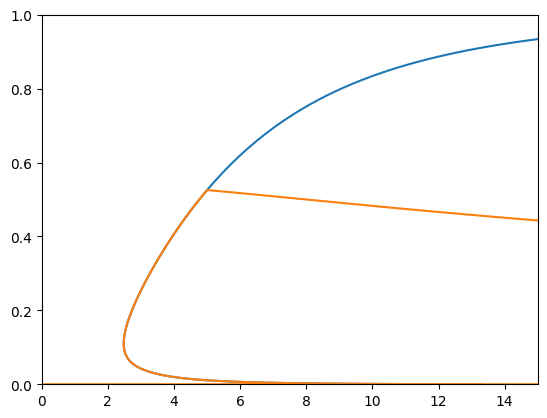

In [134]:
plt.plot(KK,R)


# for K in K_s:
R_ls2 = []
R_drs2 = []
omega_p = omega_p = F_K_OPS(5)

for X in Xs:
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)
    omega = b*X
    omega_p = min(omega,F_K_OPS(5))
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
    R_ls2.append(R_l)
    R_drs2.append(R_dr)


R02 = np.array(R_ls2)
RD2 = 2*np.array(R_drs2)
R2 = R02 -RD2
KK2 = 1/(R2/Xs)
# plt.plot(KK2,R2)
plt.plot(KK2,R2)
plt.xlim(0,15)
plt.ylim(0,1)



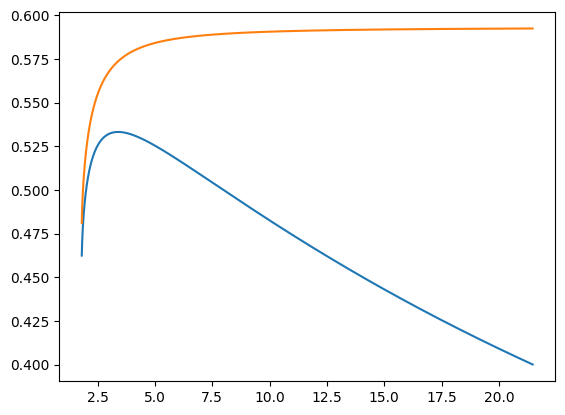

In [126]:
cond = R2 > 0.4
K_con = 1/(R2[cond]/Xs[cond])

# Xs[cond]

plt.plot(K_con,R2[cond])
plt.plot(K_con,R02[cond])


In [127]:

RP1_d = []
RP1_u = []
RPl_d = []
RPl_u = []
K1p = []

for K, r, r0 in zip(K_con, R2[cond], R02[cond]):
    OP = omega_p
    # 1. 적당한 간격으로 샘플
    rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
    diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])


    # 2. sign change 구간 찾기 (교점 후보)
    sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]

    try:
        # 첫 번째 교점
        i1 = sign_change[0]
        if len(sign_change) == 1:
            rp_left = 0
            RP1_d.append(0)
            RPl_d.append(0)
            
        else:
            rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))
            RP1_d.append(rp_left)
            RPl_d.append(RP_l(rp_left, K, r0, OP, m))


            
        # 두 번째 교점
        i2 = sign_change[-1]
        rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))

        RP1_u.append(rp_right)
        RPl_u.append(RP_l(rp_right, K, r0, OP, m))
        K1p.append(K)
    except:
        K1p.append(K)
        RP1_d.append(np.nan)
        RP1_u.append(np.nan)
        RPl_d.append(np.nan)
        RPl_u.append(np.nan)


K1p = np.array(K1p)
RP1_u = np.array(RP1_u)
RPl_u = np.array(RPl_u)
RP1_d = np.array(RP1_d)
RPl_d = np.array(RPl_d)


arg, = np.where(RP1_u<1e-13)
K1p[arg] = np.nan
RPl_u[arg] = np.nan
RP1_u[arg] = np.nan
RPl_d[arg] = np.nan
RP1_d[arg] = np.nan

/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_48391/3192933902.py:89: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  RP_l, _ = quad(integrand_Rl3, OP, OP + delta_P + OPs, args=(K * rp, OP, delta_P, m), limit=200)
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_48391/3192933902.py:99: RuntimeWarning: divide by zero encountered in scalar divide
  a = 1 / np.sqrt(K * rp * m)
/var/folders/kn/fvpnhvjx5d363mgqcf9f1ltc0000gn/T/ipykernel_48391/3192933902.py:100: RuntimeWarning: invalid value encountered in scalar subtract
  b = 4 / np.pi * a - 0.3056 * a**3
Exception ignored in: '<numba.core.cpu.CPUContext object at 0x31467a350>'
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py", line 575, in _quad
    return _quadpack._qagse(func,a,b,args,full_ou

In [ ]:
get_K_r_rp(m)

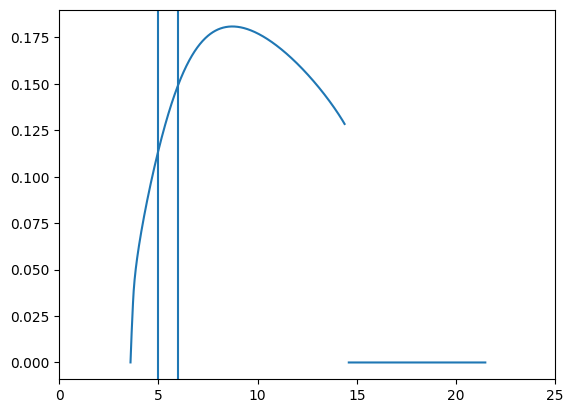

In [129]:
plt.plot(K1p,RP1_u)
# plt.plot(K1p,RP1_u)
plt.xlim(0,25)
plt.axvline(5)
plt.axvline(6)

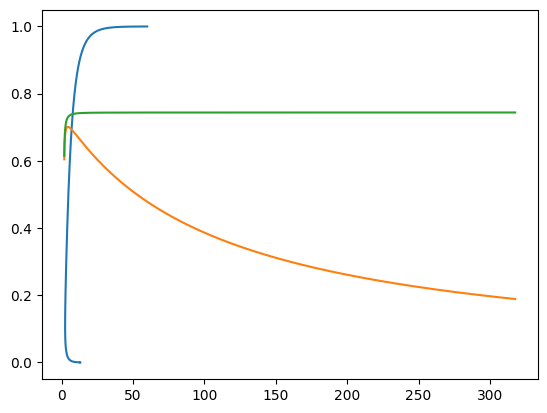

In [120]:
plt.plot(KK,R)
plt.plot(KK2,R2)
plt.plot(KK2,R02)

In [12]:

RP1_d = []
RP1_u = []
RPl_d = []
RPl_u = []
K1p = []

for K, r, r0, OP in zip(K_u, R_u, R_0u, OPS):
    # 1. 적당한 간격으로 샘플
    rps = np.r_[np.logspace(-10, -3, 100), np.linspace(0.001, (1 - r0) / 2, 100)]
    diffs = np.array([RP_diff(rp, K, r0, OP, m) for rp in rps])


    # 2. sign change 구간 찾기 (교점 후보)
    sign_change = np.where(np.diff(np.sign(diffs)) != 0)[0]

    try:
        # 첫 번째 교점
        i1 = sign_change[0]
        if len(sign_change) == 1:
            rp_left = 0
            RP1_d.append(0)
            RPl_d.append(0)
            
        else:
            rp_left = brentq(RP_diff, rps[i1], rps[i1+1], args=(K, r0, OP, m))
            RP1_d.append(rp_left)
            RPl_d.append(RP_l(rp_left, K, r0, OP, m))


            
        # 두 번째 교점
        i2 = sign_change[-1]
        rp_right = brentq(RP_diff, rps[i2-1], rps[i2+1], args=(K, r0, OP, m))

        RP1_u.append(rp_right)
        RPl_u.append(RP_l(rp_right, K, r0, OP, m))
        K1p.append(K)
    except:
        K1p.append(K)
        RP1_d.append(np.nan)
        RP1_u.append(np.nan)
        RPl_d.append(np.nan)
        RPl_u.append(np.nan)


K1p = np.array(K1p)
RP1_u = np.array(RP1_u)
RPl_u = np.array(RPl_u)
RP1_d = np.array(RP1_d)
RPl_d = np.array(RPl_d)


arg, = np.where(RP1_u<1e-13)
K1p[arg] = np.nan
RPl_u[arg] = np.nan
RP1_u[arg] = np.nan
RPl_d[arg] = np.nan
RP1_d[arg] = np.nan

In [ ]:
m = 6
R_u,R_0u,R_d,R_0d,RP1_u,RPl_u,RP1_d,RPl_d,K1p,K_start = get_K_r_rp_full(m)

In [29]:
R_u2,R_0u2,R_d2,R_0d2,RP1_u2,RPl_u2,RP1_d2,RPl_d2,K1p2,K_start2 = get_K_r_rp_full(m)


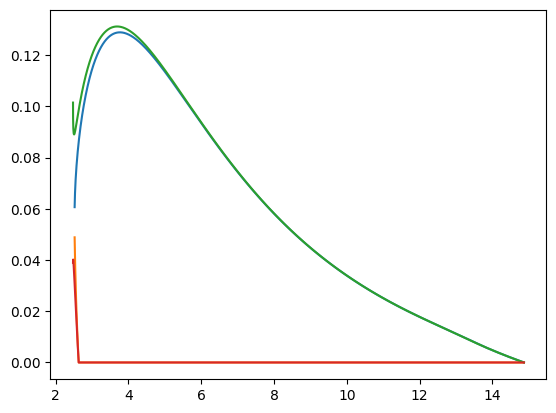

In [30]:
plt.plot(K1p,RP1_u)
plt.plot(K1p,RP1_d)

plt.plot(K1p2,RP1_u2)
plt.plot(K1p2,RP1_d2)

In [31]:
import sympy as sp

In [49]:
K,r0,theta_i,rp,omega_p,t = sp.symbols('K,r0,theta_i,r_{(+)},\omega_{(+)},t',real=True)
phi_p, phi_m = sp.symbols('phi_+, phi_-',real=True)

In [57]:
F = -K*r0*sp.sin(theta_i) + K*rp*sp.sin(phi_p - theta_i) + K*rp*sp.sin(-phi_p- theta_i)
FF = F.subs(theta_i,theta_i+phi_p)
FF.subs(phi_p,omega_p*t - sp.pi/2)


K*r0*cos(\omega_{(+)}*t + theta_i) - K*r_{(+)}*sin(theta_i) + K*r_{(+)}*sin(2*\omega_{(+)}*t + theta_i)